In [1]:
import numpy as np
from jax import numpy as jax_np
from jax import vmap as jax_vmap
from jax import grad as jax_grad
from jax import jit as jax_jit
from jax import random as jax_ran
from jax.experimental import stax,optimizers
from jax.experimental.stax import Dense, Relu

In [2]:
pip install cvnn

     |████████████████████████████████| 83 kB 1.3 MB/s eta 0:00:01
  Created wheel for cvnn: filename=cvnn-1.1.46-py2.py3-none-any.whl size=73147 sha256=1708ccb06a2edc8cadb54e0d6f10a15251bd4bbc82e45683fdbdf4327cea2b14
  Stored in directory: /Users/ky266509/Library/Caches/pip/wheels/0a/c2/38/dc644581b2dc2509d2542ef328aacfc35d9d401050d55e7119
Successfully built cvnn
Note: you may need to restart the kernel to use updated packages.


# Load data

In [2]:
dataset=np.load('data_ML_Nfreq100_Nbeta20_Nlambda20.npz',allow_pickle=True)
print(dataset.files)

['data', 'freq', 'params']


In [3]:
S= dataset['data']
Fr= dataset['freq']
parametre= dataset['params']



# I. For pre_processing we are going to use $S$ and $parametre$

###  1. Using $S$ for pre_processing

In [4]:
S=np.copy(S)
parametre=np.copy(parametre)

In [5]:
S.shape

(40000, 256, 3)

In [6]:
S=S[0:400,:,:]

In [7]:
S.shape

(400, 256, 3)

In [8]:
S[0,0,0]

(1.5750298860556053e-26+6.942531679368237e-27j)

In [9]:
parameter=parametre[0:400,:]

In [10]:
parameter

array([[ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -3.14159265e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -2.81089869e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -2.48020473e+00],
       ...,
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  1.57079633e+00,  2.48020473e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  1.57079633e+00,  2.81089869e+00],
       [ 1.00000000e-22,  2.98000000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  1.57079633e+00,  3.14159265e+00]])

####  a. Normalisation

- $ \overline{S_i}=\frac{S_i}{\rVert S_i \lVert_2},\quad \forall i \in \overline{0,400}$

In [11]:
# cette fonction normalise seulement une forme d'onde pour un canal "X","Y","Z"
def normalize(S,n,e):
# n nombre de FO, e nombre de canal
    
    return np.asarray([S[n,i,e]/np.linalg.norm(S[n,:,e]) for i in range(S.shape[1])])

# return un tableau contenant chaque forme d'onde normalisée

In [12]:
S1=normalize(S,10,0)
S1[0:2]

array([-0.0044968 -0.00040616j, -0.00448933-0.00046114j])

In [13]:
nb_fo=400 # nombre de FO utilisable pour l'apprentissage du réseau de neurones (400)

In [14]:
# cette fonction rassemble toutes les formes d'onde normalisée dans un seul tableau 
# n nombre de forme d'onde , e numéro du  canal ("X","Y","Z")
def norm(S):
    
    return (np.asarray([[normalize(S,n,e) for e in range (3)] for n in range(nb_fo)])).reshape((-1,256,3))
# pour les n=400 premières formes d'ondes

In [15]:
S_bar=norm(S)
S_bar[0,0]

array([0.0040876 +0.00180176j, 0.00406608+0.00185226j,
       0.00404455+0.00190278j])

In [16]:
S_bar.shape

(400, 256, 3)

####  b. Génération de v.a uniforme 

- $ \tilde{S_{i,k}}= \mathrm{X}_k \times \overline{S_i},\quad \forall i \in [0,1,...,400] ,\quad k \in \overline{0,5}\quad avec \quad \mathrm{X}_k \to \cup(1,10)$

In [17]:
 
X=[np.random.uniform(1,10,5) for _ in range(nb_fo)]
X[10]

array([2.62242533, 7.58347259, 6.12599026, 2.65087947, 9.26247449])

In [18]:
# multiplication de X par chaque FO
def amplitude(S,n):
    
    return np.asarray([S[n,:,:]*i for i in X[n]])

In [19]:
# cette fonction retourne les 5 amplitudes différentes de chaque FO
def amp(S):
     
    return (np.asarray([amplitude(S,n) for n in range(nb_fo)])).reshape((-1,5,256,3))
# chaque FO retourne 5 sous formes d'onde d'amplitude différentes chacune ayant 2827 fréquences 





In [20]:
S_tilde=amp(S_bar)

In [21]:
S_tilde.shape

(400, 5, 256, 3)

###  2. Using $parametre $ for pre_processing

####  a. Parameters used for learning

-  Amplitude $h_0$
-  Latitude Ecliptic $\beta$
-  Ecliptic Longitude $\lambda$

In [22]:
amplitude=parametre[:,0] # amplitude
beta=parametre[:,6] # bêta
lamb=parametre[:,7] # lambda
#parameters=[]
#zz=np.concatenate((amplitude[0:2],beta[0:2]))
parameters=np.asarray([(i,j,k)for i,j,k in zip(amplitude,beta,lamb)] )

parameters.shape



(40000, 3)

-  $ \overline{h}=[h_i]=\frac{h_0}{\rVert S_i \lVert_2},\forall i \quad\text{allant de 0 à nb_fo}$

 -  $\tilde{h}=[h_i]\times\mathrm{X}_j ,\forall i \in  \overline{0,nb}\quad et\quad j \in\overline{0,5}\quad avec \quad  \mathrm{X} \to \cup(1,10) $

$$
 \forall i \in [1,2,..400],\begin{array}{|c|c|c|c|c|}
\hline
\beta & \lambda & \overline{h} & \tilde{h}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte1}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte2}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte3}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte4}\\
\hline
\beta_i & \lambda_i & \text{cte} & \text{cte5}\\
\hline
\end{array}
$$




In [23]:
def ParametersAmpli(data): # c canal utilisé
    h_bar=[parameters[i,0]/np.linalg.norm(data[i,:,:]) for i in range(nb_fo)]
    h_tilde=np.asarray([[h_bar[j]*i for i in X[j]]for j in range(nb_fo)])
    lam=np.array([[u]*5 for u in lamb ])
    bet=np.array([[v]*5 for v in beta])
    return h_tilde,bet,lam



In [24]:
h_tilde,bet,lam=ParametersAmpli(S) # une question à posé ici : jerôme

In [25]:
final_params=np.asarray([[(i,j,k)for i,j,k in zip(h_tilde[n,:],bet[n,:],lam[n,:])] for n in range(nb_fo)])


In [39]:
final_params=np.reshape(final_params,(-1,3))

In [40]:
final_params.shape

(2000, 3)

In [41]:
final_params

array([[105.27255227,   0.        ,  -3.14159265],
       [ 84.80962257,   0.        ,  -3.14159265],
       [ 85.56901815,   0.        ,  -3.14159265],
       ...,
       [ 96.46189959,   1.57079633,   3.14159265],
       [ 45.32764068,   1.57079633,   3.14159265],
       [149.64995707,   1.57079633,   3.14159265]])

####  b. This function allows to put on the same scale our parameters (Target)

In [42]:
h_mean=np.mean(final_params[:,0])
h_max_mean=np.max(np.abs(final_params[:,0]-h_mean))

beta_mean=np.mean(final_params[:,1])
beta_max_mean=np.max(np.abs(final_params[:,1]-beta_mean))

lam_mean=np.mean(final_params[:,2])
lam_max_mean=np.max(np.abs(final_params[:,2]-lam_mean))



In [43]:
def maximum_absolute_scaling(param):
    n=3
    h,beta,lambd =[],[],[]
    for i in range(n):
        for j in range(len(param)):
            if i==0:
                H=(param[j,i]-h_mean)/h_max_mean
                h.append(H)
            elif i==1:
                Beta=(param[j,i]-beta_mean)/beta_max_mean
                beta.append(Beta)
            
            else:
                
                Lambd=(param[j,i]-lam_mean)/lam_max_mean
                lambd.append(Lambd)
                                                              
                                                              
    return h,beta,lambd
    

In [44]:
h,b,l=maximum_absolute_scaling(final_params)

In [45]:
par=np.asarray([(i,j,k)for i,j,k in zip(h,b,l)])

In [46]:
par

array([[ 0.26336074, -0.59291389, -1.        ],
       [ 0.021313  , -0.59291389, -1.        ],
       [ 0.03029559, -0.59291389, -1.        ],
       ...,
       [ 0.15914309,  1.        ,  1.        ],
       [-0.44570343,  1.        ,  1.        ],
       [ 0.78828316,  1.        ,  1.        ]])

In [47]:
par.shape

(2000, 3)

#  II. Learning

In [48]:
S_tilde=np.reshape(S_tilde,(-1,256,3))

In [49]:
S_canalXYZ=S_tilde

In [50]:
S_canalXYZ.shape

(2000, 256, 3)

###  1. Split data

In [51]:
# we can use par or final_data to do the splitting
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(S_canalXYZ,par,test_size=0.20,random_state=42)

In [52]:
X_train.shape

(1600, 256, 3)

In [53]:
X_train[0,0,:]

array([-0.00958695+1.31457924e-04j, -0.00957473+1.40677916e-05j,
       -0.00956255-1.03020006e-04j])

In [54]:
X_trainR=np.real(X_train[:,:,:]) # 1600 échantillons 
X_trainI=np.imag(X_train[:,:,:])# 1600 échantillons 
X_Tr=np.concatenate((X_trainR,X_trainI),axis=2)



In [55]:
X_testR=np.real(X_test[:,:,:]) # 400 échantillons 
X_testI=np.imag(X_test[:,:,:])# 400 échantillons 
X_Te=np.concatenate((X_testR,X_testI),axis=2)

X_Te.shape

(400, 256, 6)

In [56]:
Y_test.shape

(400, 3)

In [57]:
X_Tr[0,0,:]

array([-9.58695262e-03, -9.57473200e-03, -9.56255037e-03,  1.31457924e-04,
        1.40677916e-05, -1.03020006e-04])

In [58]:
X_Tr.shape

(1600, 256, 6)

In [59]:
Y_train.shape

(1600, 3)

###  2. Architecture réseau

####  a. Initialisation des paramètres du réseau (Hyperparamètres)

- Les paramètres du réseau sont spécifiés par une liste python de longueur $N_{\rm layers}$.
- Chaque élément de la liste est un tuple à deux éléments stokant les paramètres des $n_{\rm i}$ neurones de la couche $i^{\rm th}$.
  - Le premier élément de tuple donne des valeurs de paramètres sur les poids $w_{\rm i,i-1}$ , stockés comme un ndarray de la forme ($n_{\rm i}$,$n_{\rm i-1}$).
  - Le deuxième élément de tuple donne des valeurs de paramètres sur les biais $b_{\rm i}$, stokés comme un ndarray de la forme ($n_{\rm i}$, ).

In [60]:
from jax.nn.initializers import glorot_normal,normal
def initialize_network_layer(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys=jax_ran.split(key,len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_network_params(m, n,key):
        w_key,b_key=jax_ran.split(key)
        w_init=glorot_normal()
        b_init=normal()
        if (m==sizes[0]).any():
            ran_weigths=w_init(w_key,(n[0,0],n[0,0],m.shape[0],m.shape[1]))
            ran_biases=b_init(b_key,(n[0,0],n[0,0]))
        elif n==sizes[-1]:
        
            ran_weigths=w_init(w_key,(n,m[0,0],m[0,0]))
            ran_biases=b_init(b_key,(n,))
        else:
            ran_weigths=w_init(w_key,(n[0,0],n[0,0],m[0,0],m[0,0]))
            ran_biases=b_init(b_key,(n[0,0],n[0,0]))
        return ran_weigths,ran_biases
    
    return [initialize_network_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]



In [61]:
X_Tr[0,:,:].shape

(256, 6)

####  b. Construction du réseau de neurone

In [62]:
def network_layer_sizes(n_features,n_targets,n_layers,n_neurons_per_layer):
    dense_layer_sizes=[np.asarray(n_neurons_per_layer).reshape(-1,1)]*n_layers
    layer_sizes=[n_features,*dense_layer_sizes,n_targets]
    return layer_sizes



key=jax_ran.PRNGKey(0)
num_features, num_targets =X_Tr[0,:,:], 3          
num_layers, num_neurons_per_layer = 3, 10   # MLP à 3  couches cachées (10 units )

layer_sizes =network_layer_sizes(
    num_features, num_targets, num_layers, num_neurons_per_layer)

# Return a list of tuples of layer weights
params=initialize_network_layer(layer_sizes,key)
layer_sizes

[array([[-9.58695262e-03, -9.57473200e-03, -9.56255037e-03,
          1.31457924e-04,  1.40677916e-05, -1.03020006e-04],
        [-9.55040383e-03, -9.53828852e-03, -9.52620063e-03,
         -2.19841804e-04, -3.36433602e-04, -4.52831103e-04],
        [-9.51413640e-03, -9.50209205e-03, -9.49006388e-03,
         -5.69069791e-04, -6.85184950e-04, -8.01211705e-04],
        ...,
        [ 2.62868875e-03,  2.60769523e-03,  2.58685440e-03,
          9.40707953e-04,  9.68986730e-04,  9.97071268e-04],
        [ 2.56615848e-03,  2.54559987e-03,  2.52517120e-03,
          1.02497183e-03,  1.05269841e-03,  1.08026080e-03],
        [ 2.50486521e-03,  2.48467484e-03,  2.46459315e-03,
          1.10766855e-03,  1.13493103e-03,  1.16205743e-03]]),
 array([[10]]),
 array([[10]]),
 array([[10]]),
 3]

In [63]:
params

[(DeviceArray([[[[-1.06745828e-02,  1.00688566e-03,  1.90657508e-02,
                  -4.33682930e-03, -7.99626019e-03,  8.96459259e-03],
                 [ 3.81213235e-04,  8.53124168e-03,  3.06183496e-03,
                  -1.04510756e-02, -1.51651411e-03,  1.35899717e-02],
                 [ 9.85263847e-03,  8.36720131e-03,  3.41531588e-03,
                   9.21165571e-03, -1.37549415e-02,  8.75881815e-04],
                 ...,
                 [ 1.04341647e-02, -1.66429486e-02,  4.64828592e-03,
                  -4.45930799e-03, -8.41969252e-03,  1.21607259e-02],
                 [-3.64537374e-03,  7.96949584e-03, -9.94619820e-03,
                  -1.42408358e-02, -1.44863487e-04, -6.06406247e-03],
                 [ 7.63598969e-03,  9.65618808e-03,  1.03205424e-02,
                  -6.81126956e-03, -1.89822596e-02,  2.77542789e-03]],
  
                [[ 2.31428491e-03,  7.09828967e-03, -1.05132423e-02,
                  -2.57627480e-03, -6.54767780e-03, -1.25545473e-03],
 

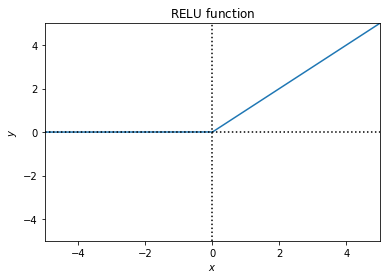

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
from jax.nn import relu

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(-5, 5)
ylim = ax.set_ylim(-5, 5)
_x = np.linspace(-5, 5, 1000)
__=ax.plot(_x, relu(_x))
xlabel = ax.set_xlabel(r'$x$')
ylabel = ax.set_ylabel(r'$y$')
title = ax.set_title(r'${\rm RELU\ function}$')
__=ax.plot(_x, np.zeros_like(_x), ':', color='k')
__=ax.plot(np.zeros_like(_x), _x, ':', color='k')

###  3. Feedforward function 

In [65]:
def predict(params,in_array):
    """ Chaque neurone est appliqué à la fonction d'activation y=w*x+b,
     seulement la dernière couche (couche de sortie) qui n'utilise pas de cette fonction d'activation (régression) 
     utilisation de la fonction identité
     
     Paramètres de la fonction:
     --------------------------------
       params: list de tuple 
            paramètre du réseau , avec une liste d'élément par couche (w,b)
       in_array: ndarray 
            shape de la forme (batch_size, n_features)
    
     Returns
     -------------------------------
        preds: ndarray
             ndarray dont le shape est (batch_size, n_targets)
     
     """
    
    activations = in_array
    
    # Boucle itérative sur chaque couche dense exceptée la dernière
    
    for w, b in params[:-1]:
        outputs = jax_np.einsum('mjt,ikjt ->mik',activations,w)+b[np.newaxis,:,:]  # Application de la transformation linéaire
        activations = relu(outputs)  #  apply nonlinear activation
        
    #  Now for the final layer
    w_final, b_final = params[-1] 
    final_outputs = jax_np.einsum('mik,sik ->ms',activations,w_final) + b_final[np.newaxis,:] 
    return final_outputs  # Final layer is just w*x + b with no activation

In [66]:
pred=predict(params,X_Tr)

In [67]:
pred[:,0]

DeviceArray([0.01929848, 0.01503134, 0.01643626, ..., 0.01728384,
             0.01169373, 0.03823327], dtype=float32)

#### Vectorisation des prédictions du réseau avec vmap

- La fonction feedforward_prediction n'accepte que les arguments scalaires. Le vectoriser avec vmap simplifiera l'apprentissage par lots( batch-training) du réseau , plutôt que l'entrainement avec un point de données à la fois.

In [54]:
batched_predict=jax_vmap(predict, in_axes=[0, None])

###  4. Loss function

In [68]:
def mse_loss(params, in_array, targets):
    pred = predict(params,in_array)
    diff_Ampli = [(pred[i,0]-targets[i,0])**2/pred.shape[0] for i in range(pred.shape[0])]
    diff_Beta = [(pred[j,1]-targets[j,1])**2/pred.shape[0] for j in range(pred.shape[0])]
    diff_lambda = [(pred[k,2]-targets[k,2])**2/pred.shape[0] for k in range(pred.shape[0])]
    error=sum(diff_Ampli) +sum(diff_Beta)+sum(diff_lambda)
    return error

In [69]:
mse_loss(params, X_Tr, Y_train)

DeviceArray(0.7635857, dtype=float32)

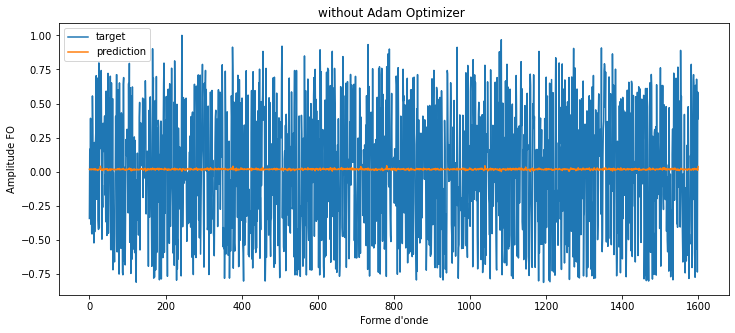

In [70]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,0],label='target')
plt.plot(pred[:,0],label='prediction')
plt.ylabel('Amplitude FO')
plt.xlabel("Forme d'onde")
plt.title('without Adam Optimizer ')
plt.legend()

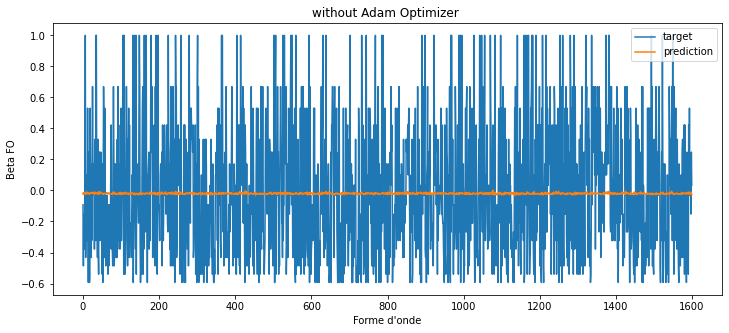

In [71]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,1],label='target')
plt.plot(pred[:,1],label='prediction')
plt.ylabel('Beta FO')
plt.xlabel("Forme d'onde")
plt.title('without Adam Optimizer ')
plt.legend()

### 5. Backpropagation 

In [72]:
num_epochs = 300

In [73]:

# Defining an optimizer in Jax
learning_rate= 1e-3
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params) # init avce les paramètre du réseau

# Define a compiled update step
@jax_jit
def update(i, opt_state, x, y):
    p = get_params(opt_state)
    g = jax_grad(mse_loss)(p, x, y)
    loss=mse_loss(p,x,y)
    return opt_update(i, g, opt_state),loss





###  6. Training Loop (à retoucher)

In [74]:
Loss=[]
# Adam optimisation 
for i in range(num_epochs):
    opt_state ,loss = update(i, opt_state, X_Tr, Y_train)
   # print(" epoch:{0},loss={1}".format(i,loss))
    Loss.append(loss)
net_params = get_params(opt_state)

#  7. Enregistrer les paramètres finaux dans un fichier

In [75]:
import pickle
#Enregistrement des variables dans un fichier (sous forme de liste)
para_test=[net_params,Loss,[h_mean,h_max_mean],[beta_mean,beta_max_mean],[lam_mean,lam_max_mean]]
f=open("paramètres","wb")
pickle.dump(para_test, f)
f.close()

In [76]:
import pickle
f=open("paramètres","rb")
ff=pickle.load(f)

In [77]:
ff[1]

[array(0.76358503, dtype=float32),
 array(0.7494959, dtype=float32),
 array(0.7355197, dtype=float32),
 array(0.7190816, dtype=float32),
 array(0.7000371, dtype=float32),
 array(0.67846936, dtype=float32),
 array(0.6549184, dtype=float32),
 array(0.62916505, dtype=float32),
 array(0.60027444, dtype=float32),
 array(0.5675175, dtype=float32),
 array(0.5316635, dtype=float32),
 array(0.49476188, dtype=float32),
 array(0.4590016, dtype=float32),
 array(0.42676672, dtype=float32),
 array(0.40058225, dtype=float32),
 array(0.38198042, dtype=float32),
 array(0.36898166, dtype=float32),
 array(0.3571977, dtype=float32),
 array(0.34425414, dtype=float32),
 array(0.33015808, dtype=float32),
 array(0.3163822, dtype=float32),
 array(0.3040998, dtype=float32),
 array(0.2930669, dtype=float32),
 array(0.28338054, dtype=float32),
 array(0.2751386, dtype=float32),
 array(0.26734957, dtype=float32),
 array(0.25976056, dtype=float32),
 array(0.2522392, dtype=float32),
 array(0.24472684, dtype=float32),

In [78]:
para_test[3]

[0.584681296414644, 0.9861150303802526]

#  III. Analyse des résultats sur le Train_Set

###  1. Visualisation de la courbe de déscente de gradient

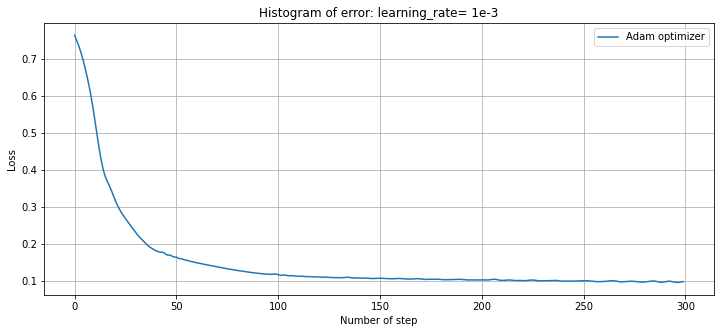

In [102]:
plt.figure(figsize=(12,5))
x=np.arange(num_epochs)
plt.plot(ff[1],label='Adam optimizer')
plt.xlabel('Number of step')
plt.ylabel('Loss')
plt.title(r'Histogram of error: learning_rate= 1e-3')
plt.legend()
plt.grid()

###  2. Prédiction et observation 

In [103]:
# prediction sur le train set
pred_Adam=predict(ff[0],X_Tr)

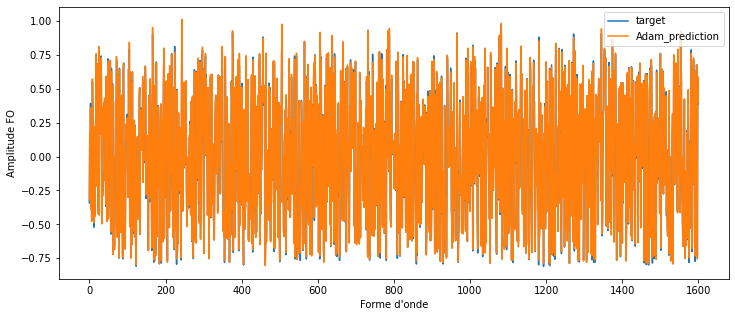

In [104]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,0],label='target')
plt.plot(pred_Adam[:,0],label='Adam_prediction')
plt.ylabel('Amplitude FO')
plt.xlabel("Forme d'onde")
plt.legend()

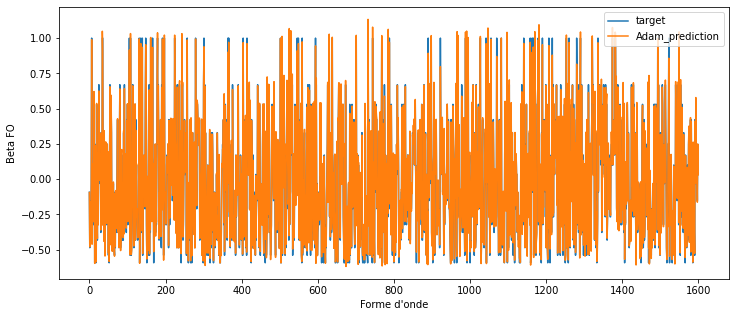

In [82]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,1],label='target')
plt.plot(pred_Adam[:,1],label='Adam_prediction')
plt.ylabel('Beta FO')
plt.xlabel("Forme d'onde")
plt.legend()

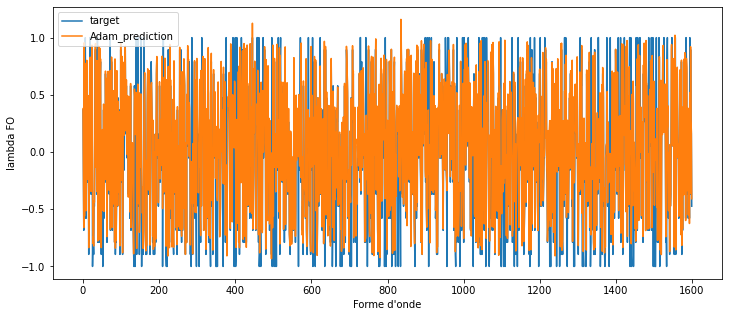

In [83]:
plt.figure(figsize=(12,5))
plt.plot(Y_train[:,2],label='target')
plt.plot(pred_Adam[:,2],label='Adam_prediction')
plt.ylabel('lambda FO')
plt.xlabel("Forme d'onde")
plt.legend()

# IV. Evaluation du modèle

In [84]:
Y_test

array([[ 0.26383454,  0.66952846,  0.26315789],
       [-0.07918916, -0.43212303,  0.05263158],
       [ 0.6742657 ,  0.17121666, -0.36842105],
       ...,
       [-0.07236252,  0.53052665, -0.26315789],
       [-0.53937964, -0.48597046,  0.26315789],
       [ 0.68398314, -0.32287032, -0.26315789]])

###  1. Remise en forme des paramètres à prédire (signaux physiques)

In [85]:

def real_parameter_prediction(param_test,in_array):
    prediction=predict(param_test[0],in_array)
    Amp_pred=prediction[:,0]*param_test[2][1] + param_test[2][0]
    Bet_pred=prediction[:,1]*param_test[3][1] + param_test[3][0]
    lam_pred=prediction[:,2]*param_test[4][1] + param_test[4][0]
    return np.asarray([(i,j,k)for i,j,k in zip(Amp_pred,Bet_pred,lam_pred)])

In [86]:
predT=real_parameter_prediction(ff,X_Te)

In [87]:
predT

array([[ 1.0279929e+02,  1.2234627e+00,  1.0659133e+00],
       [ 7.7103516e+01,  1.7654571e-01,  1.8716303e-01],
       [ 1.3821069e+02,  7.4276453e-01, -1.1258526e+00],
       ...,
       [ 7.6752426e+01,  1.1438653e+00, -9.4888639e-01],
       [ 3.6977600e+01,  9.1164410e-02,  8.8701749e-01],
       [ 1.4370580e+02,  2.2843543e-01, -6.3184780e-01]], dtype=float32)

In [88]:
def Y_test_transform(param_test,Y):
    h_real=np.dot(Y[:,0],param_test[2][1]) + param_test[2][0]
    b_real=np.dot(Y[:,1],param_test[3][1]) + param_test[3][0]
    l_real=np.dot(Y[:,2],param_test[4][1]) + param_test[4][0]
    return np.asarray([(i,j,k)for i,j,k in zip(h_real,b_real,l_real)])

In [89]:
Y_TT=Y_test_transform(ff,Y_test)

In [90]:
mse_loss(ff[0], X_Te, Y_TT)

DeviceArray(8469.792, dtype=float32)

###  2. Visualisation des prédictions sur les trois paramètres

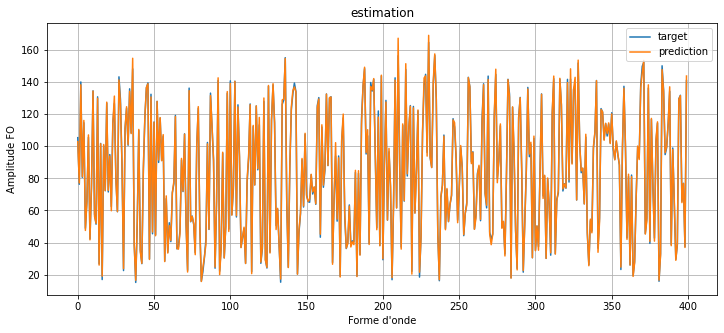

In [91]:
plt.figure(figsize=(12,5))
plt.plot(Y_TT[:,0],label='target')
plt.plot(predT[:,0],label='prediction')
plt.ylabel('Amplitude FO')
plt.xlabel("Forme d'onde")
plt.title('estimation')
plt.grid()
plt.legend()

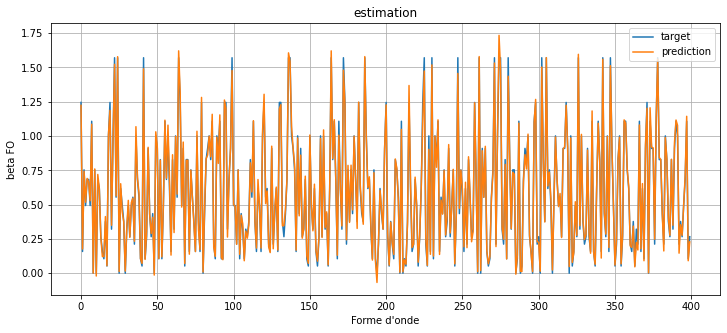

In [92]:
plt.figure(figsize=(12,5))
plt.plot(Y_TT[:,1],label='target')
plt.plot(predT[:,1],label='prediction')
plt.ylabel('beta FO')
plt.xlabel("Forme d'onde")
plt.title('estimation')
plt.grid()
plt.legend()

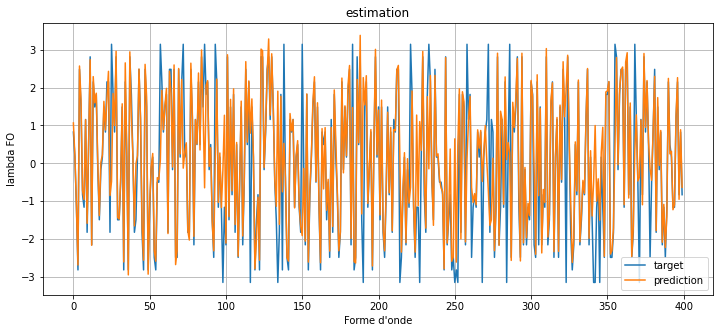

In [94]:
plt.figure(figsize=(12,5))
plt.plot(Y_TT[:,2],label='target')
plt.plot(predT[:,2],label='prediction')
plt.ylabel('lambda FO')
plt.xlabel("Forme d'onde")
plt.title('estimation')
plt.grid()
plt.legend()

###  3. Histogramme des erreurs de prediction sur le Test_Set 

In [95]:
def LOSS_Hist(params,in_array,targets):
    preds=real_parameter_prediction(params,in_array)
    a_error =[np.linalg.norm(preds[i,0]-targets[i,0])/np.linalg.norm(targets[:,0],axis=0) for i in range(preds.shape[0])]
    b_error =[np.linalg.norm(preds[j,1]-targets[j,1])/np.linalg.norm(targets[:,1],axis=0) for j in range(preds.shape[0])]
    l_error =[np.linalg.norm(preds[k,2]-targets[k,2])/np.linalg.norm(targets[:,2],axis=0) for k in range(preds.shape[0])]
    return -20*np.log10(a_error),-20*np.log10(b_error),-20*np.log10(l_error)

In [96]:
Y_TT

array([[ 1.05312608e+02,  1.24491337e+00,  8.26734909e-01],
       [ 7.63130806e+01,  1.58558281e-01,  1.65346982e-01],
       [ 1.40010820e+02,  7.53520617e-01, -1.15742887e+00],
       ...,
       [ 7.68902113e+01,  1.10784160e+00, -8.26734909e-01],
       [ 3.74081709e+01,  1.05458525e-01,  8.26734909e-01],
       [ 1.40832341e+02,  2.66294017e-01, -8.26734909e-01]])

In [97]:
a_err,b_err,l_err=LOSS_Hist(ff,X_Te,Y_TT)

Text(0.5, 1.0, "Histogramme des erreurs d'amplitude sur le Test_Set")

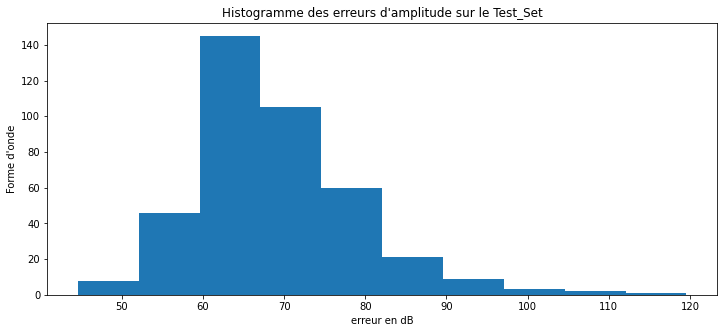

In [98]:
plt.figure(figsize=(12,5))
out=plt.hist(np.array(a_err))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs d\'amplitude sur le Test_Set')


Text(0.5, 1.0, 'Histogramme des erreurs du paramètre beta sur le Test_Set')

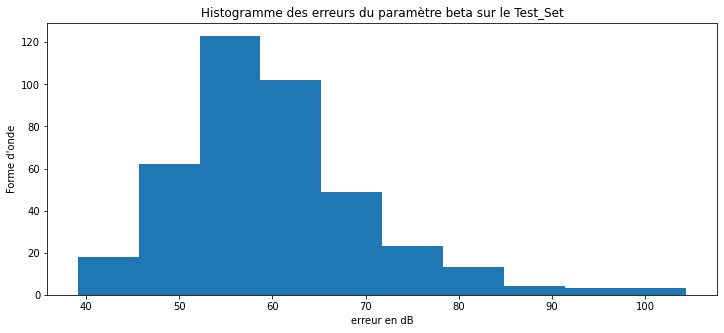

In [100]:
plt.figure(figsize=(12,5))
plt.hist(np.array(b_err))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs du paramètre beta sur le Test_Set')

Text(0.5, 1.0, 'Histogramme des erreurs du paramètre lambda sur le Test_Set')

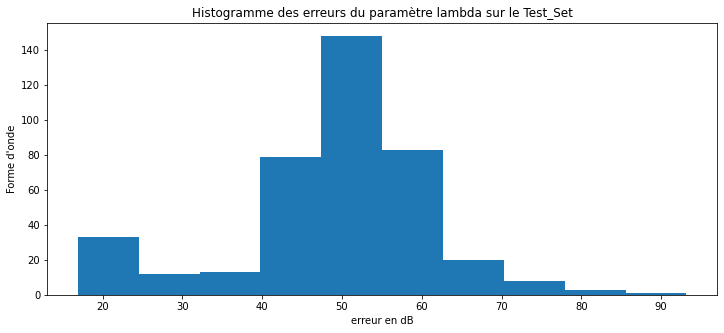

In [101]:
plt.figure(figsize=(12,5))
plt.hist(np.array(l_err))
plt.xlabel('erreur en dB')
plt.ylabel('Forme d\'onde')
plt.title('Histogramme des erreurs du paramètre lambda sur le Test_Set')